# Week 5 Coding Challenge


Your task is to develop a model that predicts whether a biopsied breast cell is benign (not harmful) or malignant (cancerous), given a set of attributes about the cell. 


Description of challenge is:
The dataset consists of 699 cells for which you have the following features:

1. Sample code number: id number 
2. Clump Thickness: 1 - 10 
3. Uniformity of Cell Size: 1 - 10 
4. Uniformity of Cell Shape: 1 - 10 
5. Marginal Adhesion: 1 - 10 
6. Single Epithelial Cell Size: 1 - 10 
7. Bare Nuclei: 1 - 10 
8. Bland Chromatin: 1 - 10 
9. Normal Nucleoli: 1 - 10 
10. Mitoses: 1 - 10 
11. Class: (2 for benign, 4 for malignant)

## Step 0 - Load libraries.

In [1]:
%pylab inline
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation
from sklearn.metrics import roc_curve, auc, roc_auc_score, f1_score, recall_score
from scipy import interp

Populating the interactive namespace from numpy and matplotlib


## Step 1 - Read data into a dataframe.

In [2]:
data_file = './data/breast-cancer-wisconsin.data' #this will have to be changed depending on where data is stored.
data = pd.read_csv(data_file,names=['id','thickness','uni_cell_size','uni_cell_shape','adhesion','single_epi_cell_size','bare_nuclei','bland_chromatin','norm_nucleoli','mitosis','class'])

In [3]:
#Reclassify 2 (benign) = 0, 4 (malignant) = 1
data['result'] = data['class'].map({2:0, 4:1})

In [4]:
#examine data by eye to see what I am dealing with.
data.head(3)

,id,thickness,uni_cell_size,uni_cell_shape,adhesion,single_epi_cell_size,bare_nuclei,bland_chromatin,norm_nucleoli,mitosis,class,result
0,1000025,5,1,1,1,2,1,3,1,1,2,0
1,1002945,5,4,4,5,7,10,3,2,1,2,0
2,1015425,3,1,1,1,2,2,3,1,1,2,0


In [5]:
#check for missing data
data.describe()

,id,thickness,uni_cell_size,uni_cell_shape,adhesion,single_epi_cell_size,bland_chromatin,norm_nucleoli,mitosis,class,result
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,2.689557,0.344778
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.951273,0.475636
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,0.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000,0.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000,0.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,4.000000,1.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000,1.000000


In [6]:
#make a list of feature names for future use.
features = ['thickness','uni_cell_size','uni_cell_shape','adhesion','single_epi_cell_size','bare_nuclei','bland_chromatin','norm_nucleoli','mitosis']

In [7]:
#Noticed some '?' in the data. Probably means missing values. Need to fill those in.
for f in features:
    print(f)
    try:
        foo = data[f].astype(int)
        print('Success')
    except:
        print('Failure')
    print('--------')

thickness
Success
--------
uni_cell_size
Success
--------
uni_cell_shape
Success
--------
adhesion
Success
--------
single_epi_cell_size
Success
--------
bare_nuclei
Failure
--------
bland_chromatin
Success
--------
norm_nucleoli
Success
--------
mitosis
Success
--------


bare_nuclei appears to need some cleaning.

## Step 2 - Exploration

In [8]:
#check for class imbalance.
totalPos = sum(data['result'])
totalNeg = len(data['result'])-totalPos
ratio = float(totalNeg)/float(totalPos)
print('Total Malignant = ',totalPos)
print('Total Benign = ', totalNeg)
print('Ratio (Benign:Malignant) = ', ratio)

Total Malignant =  241
Total Benign =  458
Ratio (Benign:Malignant) =  1.900414937759336


Is this a biased dataset? I did not think the ratio of 2:1 benign to malignant in reality, but what do I know. Either way, this is a weak class imbalance, and may not become a problem later. Should check the impact of class balancing.

### Making some histograms to get a feel for the distribution of features.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd0d0be30b8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fd0ce5b5400>]], dtype=object)

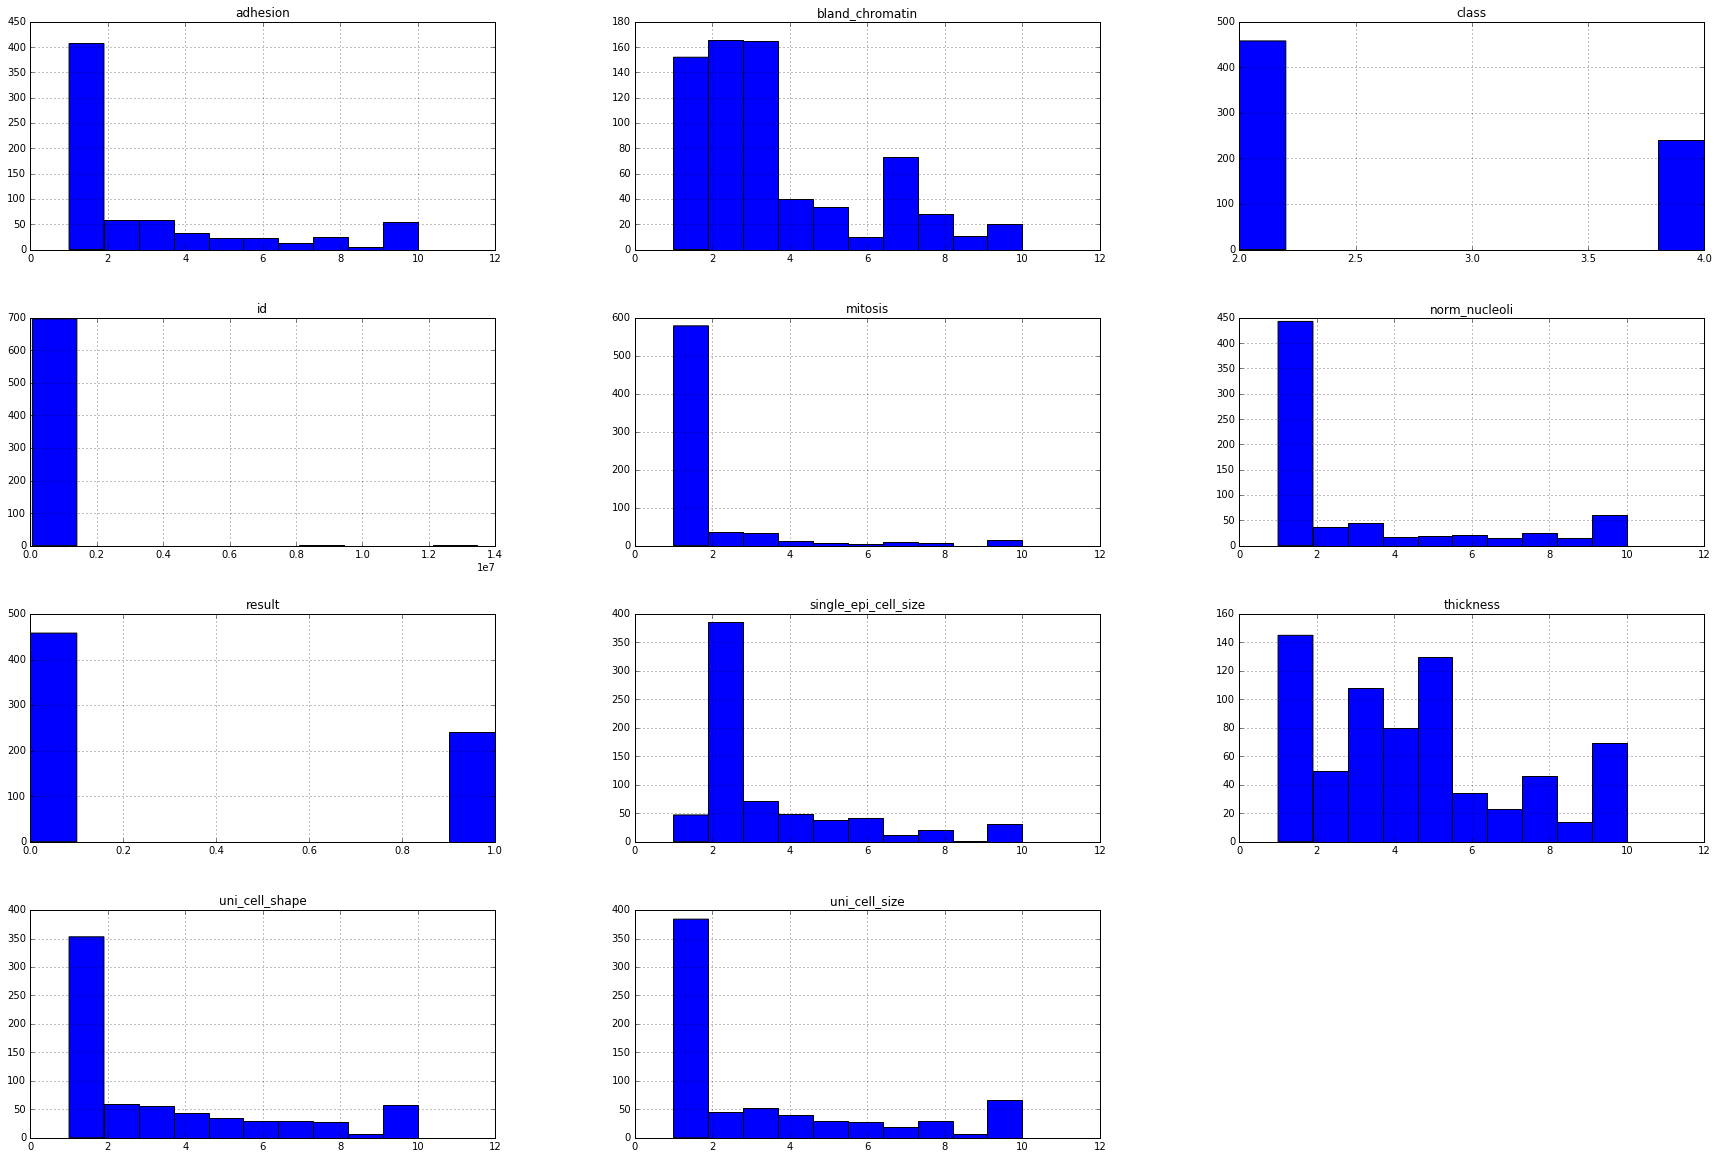

In [9]:
data.hist(figsize=(30,20)) #histograms of all data.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd0ccee7b70>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fd0cd8d8dd8>]], dtype=object)

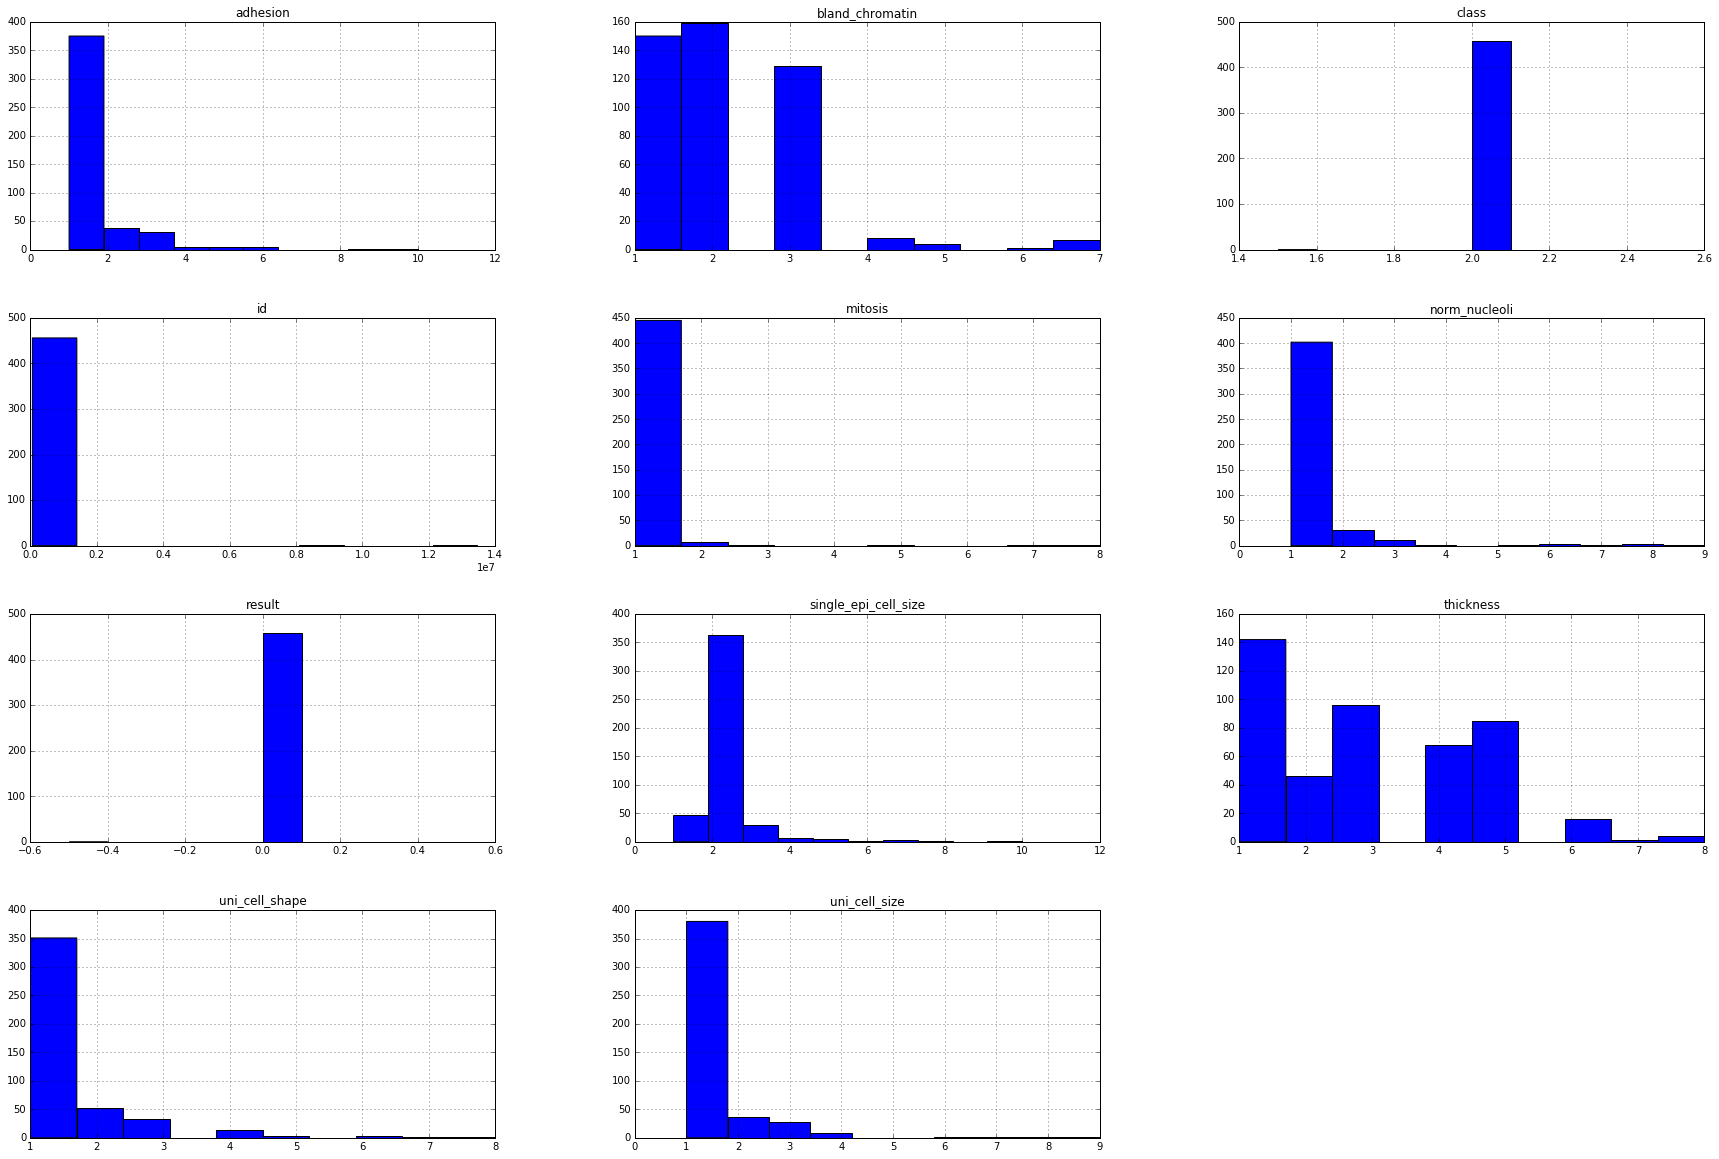

In [10]:
data[data.result==0].hist(figsize=(30,20)) #histograms of all benign.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd0cd5da550>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fd0cc48b5c0>]], dtype=object)

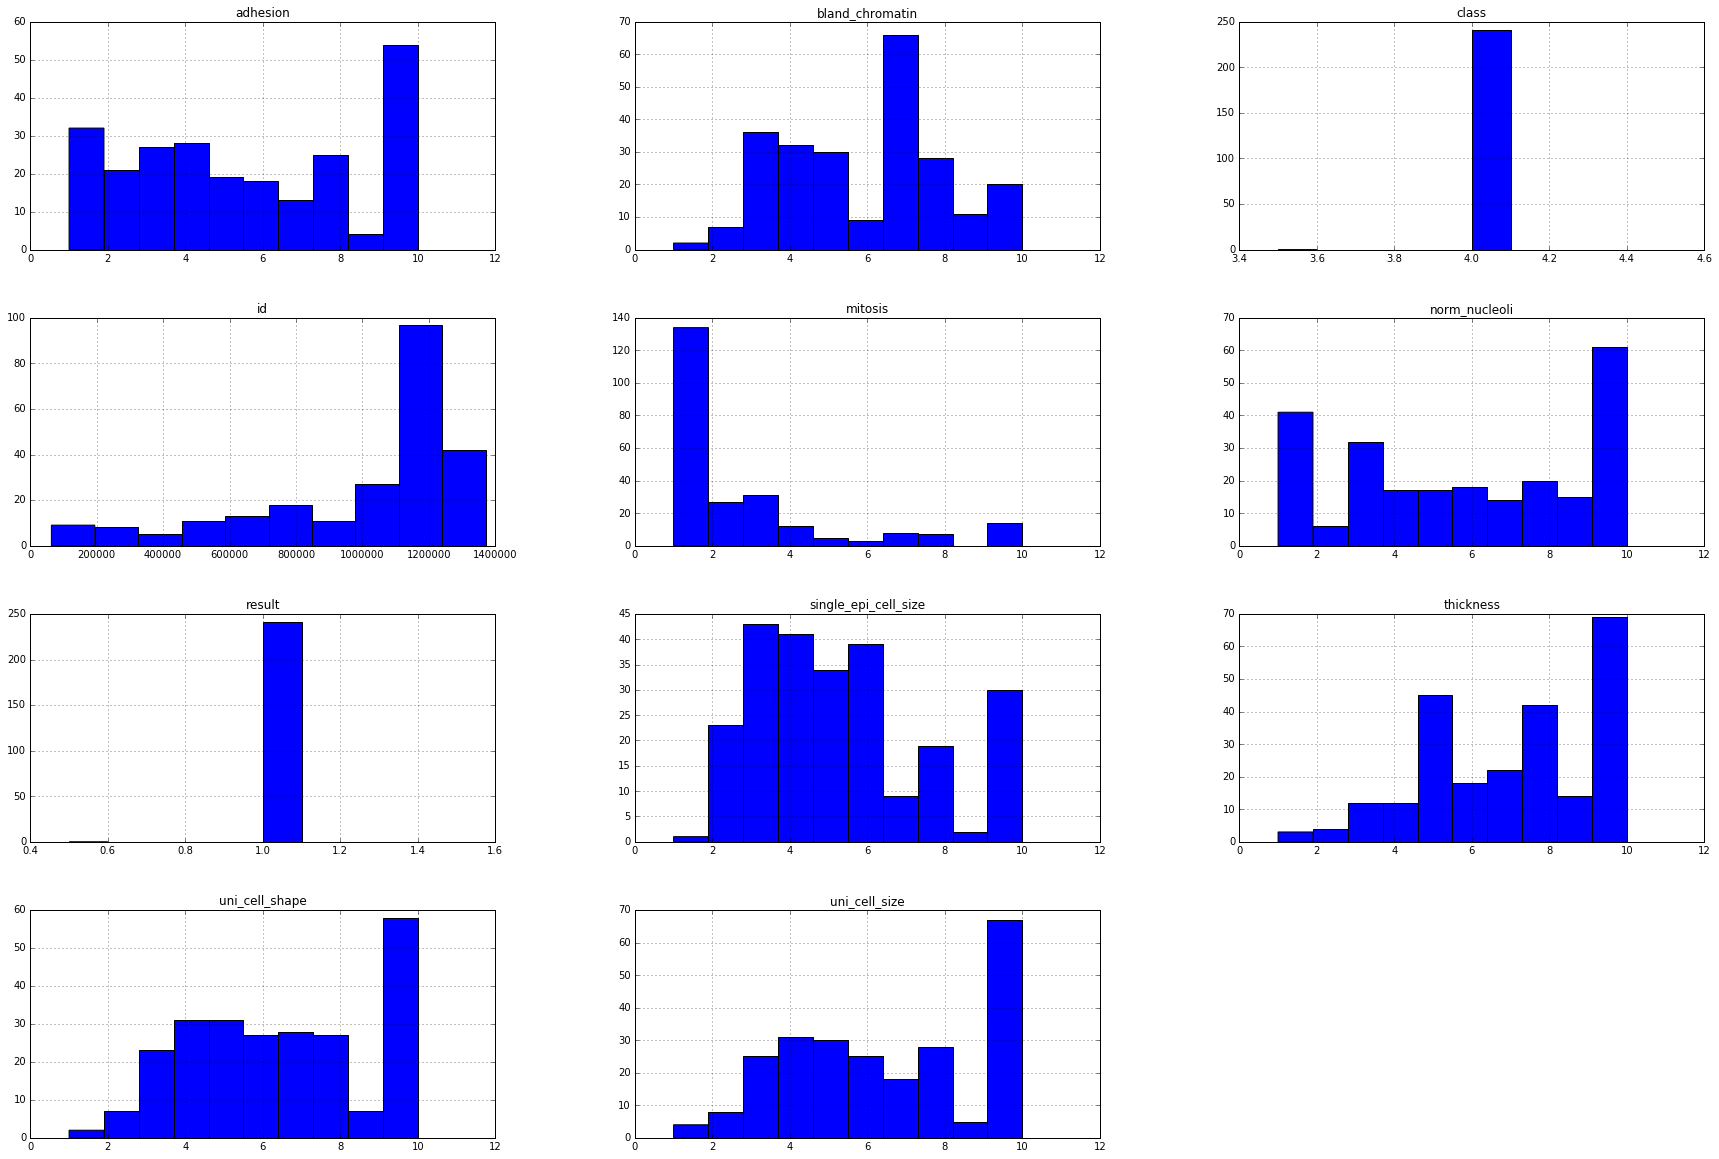

In [11]:
data[data.result==1].hist(figsize=(30,20)) #histograms of all malignant.

So some clear relationships here. Malignant tends to have higher values in each category than benign. That being said, they do not **require** high numbers.

Also note that features are NOT gaussian. So I will use a multinomial naive bayes.

### Checking correlations in data to see how good linar models might do.

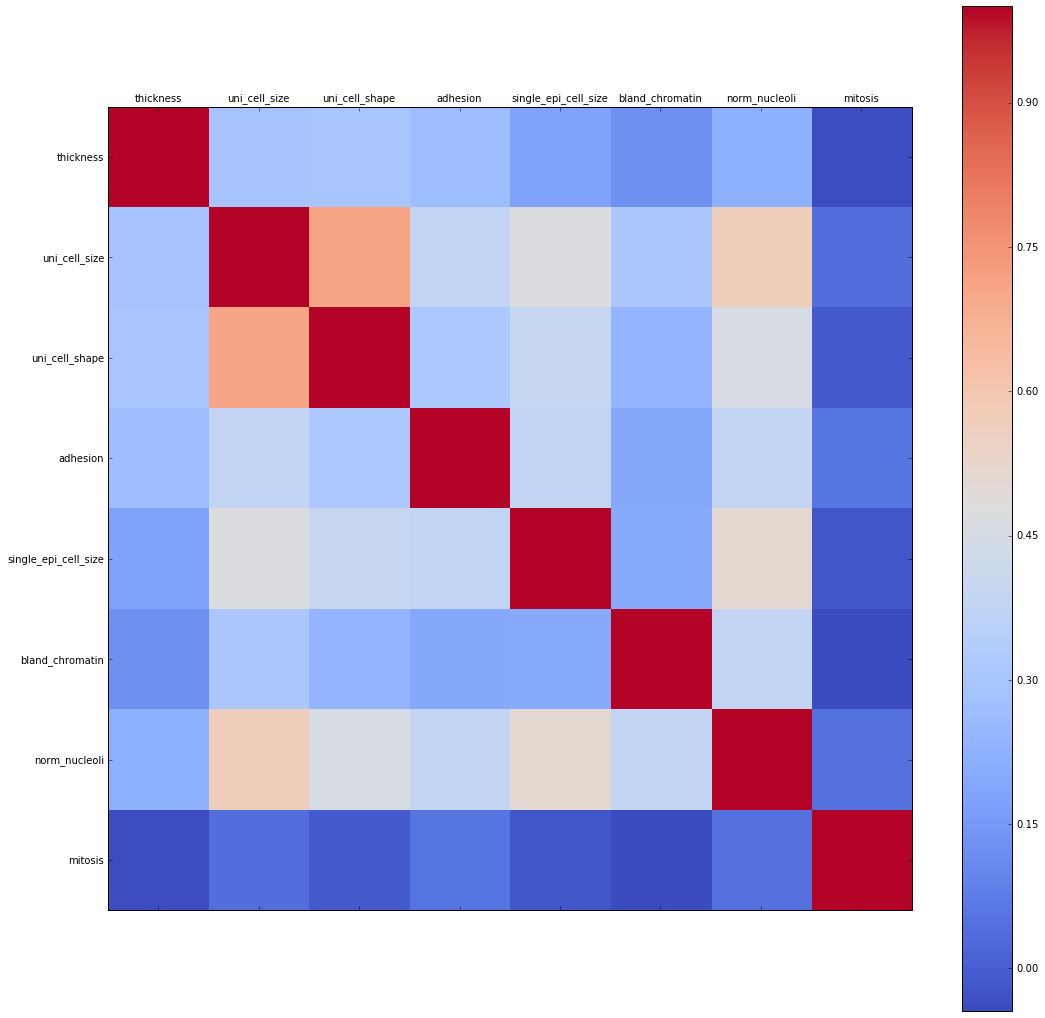

In [12]:
#check correlations for benign
corr = data[data.result==0][features].corr(method='pearson')
fig, ax = plt.subplots(figsize=(18,18))
ax.matshow(corr)
plt.xticks(range(len(corr.columns)),corr.columns)
plt.yticks(range(len(corr.columns)),corr.columns)
cax = ax.imshow(corr,interpolation='nearest',cmap=cm.coolwarm)
cb = plt.colorbar(cax)

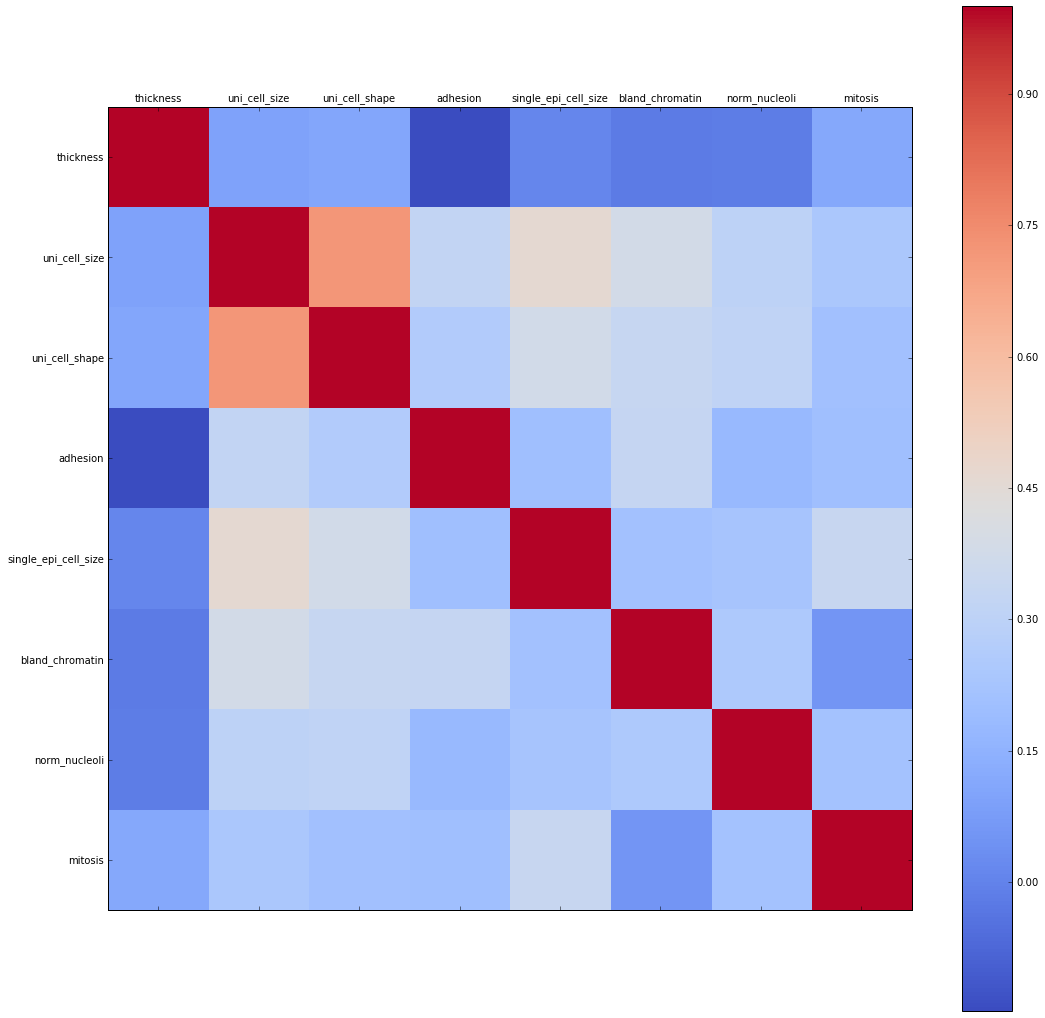

In [13]:
#check correlations for malignant
corr = data[data.result==1][features].corr(method='pearson')
fig, ax = plt.subplots(figsize=(18,18))
ax.matshow(corr)
plt.xticks(range(len(corr.columns)),corr.columns)
plt.yticks(range(len(corr.columns)),corr.columns)
cax = ax.imshow(corr,interpolation='nearest',cmap=cm.coolwarm)
cb = plt.colorbar(cax)

### Try to clean bare_nuclei

In [14]:
#split data into having bare_nuclei and not.
clean = pd.DataFrame()
dirty = pd.DataFrame()
clean = data[data.bare_nuclei != '?'][features]
clean.bare_nuclei = clean.bare_nuclei.astype(int)
dirty = data[data.bare_nuclei == '?'][features]

In [15]:
dirty

,thickness,uni_cell_size,uni_cell_shape,adhesion,single_epi_cell_size,bare_nuclei,bland_chromatin,norm_nucleoli,mitosis
23,8,4,5,1,2,?,7,3,1
40,6,6,6,9,6,?,7,8,1
139,1,1,1,1,1,?,2,1,1
145,1,1,3,1,2,?,2,1,1
158,1,1,2,1,3,?,1,1,1
164,5,1,1,1,2,?,3,1,1
235,3,1,4,1,2,?,3,1,1
249,3,1,1,1,2,?,3,1,1
275,3,1,3,1,2,?,2,1,1
292,8,8,8,1,2,?,6,10,1


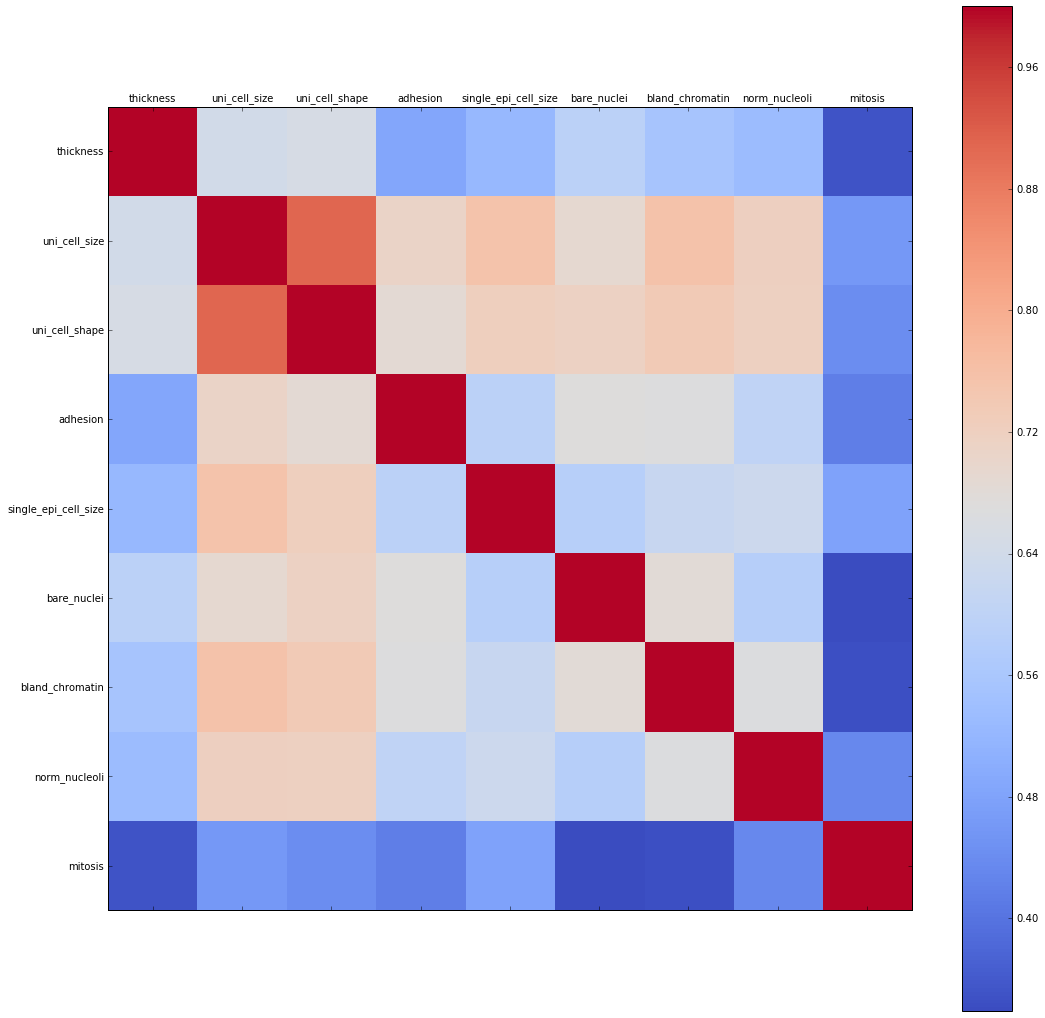

In [16]:
#check correlations to bare_nuclei
corr = clean.corr(method='pearson')
fig, ax = plt.subplots(figsize=(18,18))
ax.matshow(corr)
plt.xticks(range(len(corr.columns)),corr.columns)
plt.yticks(range(len(corr.columns)),corr.columns)
cax = ax.imshow(corr,interpolation='nearest',cmap=cm.coolwarm)
cb = plt.colorbar(cax)

I could use uni_cell_size and uni_cell_shape to predict bare_nuclei, but lets use a linear regression model with everything since it is more fun.

In [17]:
print(features)

['thickness', 'uni_cell_size', 'uni_cell_shape', 'adhesion', 'single_epi_cell_size', 'bare_nuclei', 'bland_chromatin', 'norm_nucleoli', 'mitosis']


In [18]:
#set up the features to be used in predicting (or cleaning) bare_nuclei.
new_features = features
res = new_features.pop(5)
print(res)
print(new_features)

bare_nuclei
['thickness', 'uni_cell_size', 'uni_cell_shape', 'adhesion', 'single_epi_cell_size', 'bland_chromatin', 'norm_nucleoli', 'mitosis']


#### I use LinearSVC below. I tried a regression SVM, but it did not do as well. So apparantly treating as classes instead of continuous for bare_nuclei will do better.

In [19]:
#Use linearSVC model to fit bare_nuclei (not using result)
lin = svm.LinearSVC()
X_train, X_test, y_train, y_test = cross_validation.train_test_split(clean[new_features], clean[res], test_size=0.3, random_state=0)

In [20]:
lin = lin.fit(X_train,y_train)

In [21]:
Z = lin.predict(X_test)
#convert to integers
Z = np.round(Z,0).astype(int)

In [22]:
count = 0
for i in range(0,len(Z)):
    if Z[i] == y_test.iloc[i]:
        count += 1
acc = count/len(Z)
print('Accuracy = ',acc)

Accuracy =  0.7170731707317073


Not great, but it will do for this data challenge.

In [23]:
#train full model now.
lin = lin.fit(clean[new_features],clean[res])

In [24]:
#Clean data.
new_bare_nuclei = list()
for i in range(0,len(data.index)):
    try:
        foo = data['bare_nuclei'].iloc[i].astype(int)[0]
    except:
        foo = lin.predict(data[new_features].iloc[i].reshape(1,-1))[0]
    new_bare_nuclei.append(foo)
data['new_bare_nuclei'] = new_bare_nuclei

# Step 3 - Fit some models.

From the exploration, I feel that linear models should do a decent job. So I am going to use the following:
1) Logistic Regression
2) Linear SVM
3) Naive Bayes
4) Random Forest
Random forest is in there just to see if my assumption of linear relationships is bad.

In [25]:
features.append('new_bare_nuclei')
print(features)

['thickness', 'uni_cell_size', 'uni_cell_shape', 'adhesion', 'single_epi_cell_size', 'bland_chromatin', 'norm_nucleoli', 'mitosis', 'new_bare_nuclei']


In [26]:
#split data into train
X_to_split_train, X_test, y_to_split_train, y_test = cross_validation.train_test_split(data[features], data.result, test_size=0.2, random_state=0)
X_train, X_CV, y_train, y_CV = cross_validation.train_test_split(X_to_split_train, y_to_split_train, test_size=0.25, random_state=0)

### Logistic Regresion

In [27]:
lr = LogisticRegression()
lr = lr.fit(pd.concat([X_train,X_CV]),pd.concat([y_train,y_CV]))

In [28]:
y_score = lr.decision_function(X_test)

In [29]:
n_classes = 2
fpr_lr = dict()
tpr_lr = dict()
roc_auc_lr = dict()
fpr_lr, tpr_lr, thresh_lr = roc_curve(y_test,y_score)
roc_auc_lr = auc(fpr_lr,tpr_lr)
roc_score_lr = roc_auc_score(y_test,y_score)
recall_lr = recall_score(y_test,lr.predict(X_test))

### Linear SVM - called LinearSVC in sklearn

In [30]:
lsvc = svm.LinearSVC(class_weight='balanced')
lsvc = lsvc.fit(pd.concat([X_train,X_CV]),pd.concat([y_train,y_CV]))
y_score = lsvc.decision_function(X_test)
n_classes = 2
fpr_lsvc = dict()
tpr_lsvc = dict()
roc_auc_lsvc = dict()
fpr_lsvc, tpr_lsvc, thresh_lsvc = roc_curve(y_test,y_score)
roc_auc_lsvc = auc(fpr_lsvc,tpr_lsvc)
roc_score_lsvc = roc_auc_score(y_test,y_score)
recall_lsvc = recall_score(y_test,lsvc.predict(X_test))

### Naive Bayes - GaussianNB (not a good guess given the exploration results, but best of options for NB)

In [31]:
nb = GaussianNB()
nb = nb.fit(pd.concat([X_train,X_CV]),pd.concat([y_train,y_CV]))
y_score = nb.predict_proba(X_test)[:,1]
n_classes = 2
fpr_nb = dict()
tpr_nb = dict()
roc_auc_nb = dict()
fpr_nb, tpr_nb, thresh_nb = roc_curve(y_test,y_score)
roc_auc_nb = auc(fpr_nb,tpr_nb)
roc_score_nb = roc_auc_score(y_test,y_score)
recall_nb = recall_score(y_test,nb.predict(X_test))

### Random Forest

In [32]:
rf = RandomForestClassifier(class_weight='balanced')
rf = rf.fit(pd.concat([X_train,X_CV]),pd.concat([y_train,y_CV]))
y_score = rf.predict_proba(X_test)[:,1]
n_classes = 2
fpr_rf = dict()
tpr_rf = dict()
roc_auc_rf = dict()
fpr_rf, tpr_rf, thresh_rf = roc_curve(y_test,y_score)
roc_auc_rf = auc(fpr_rf,tpr_rf)
roc_score_rf = roc_auc_score(y_test,y_score)
recall_rf = recall_score(y_test,rf.predict(X_test))

# Compare Final models and scores.

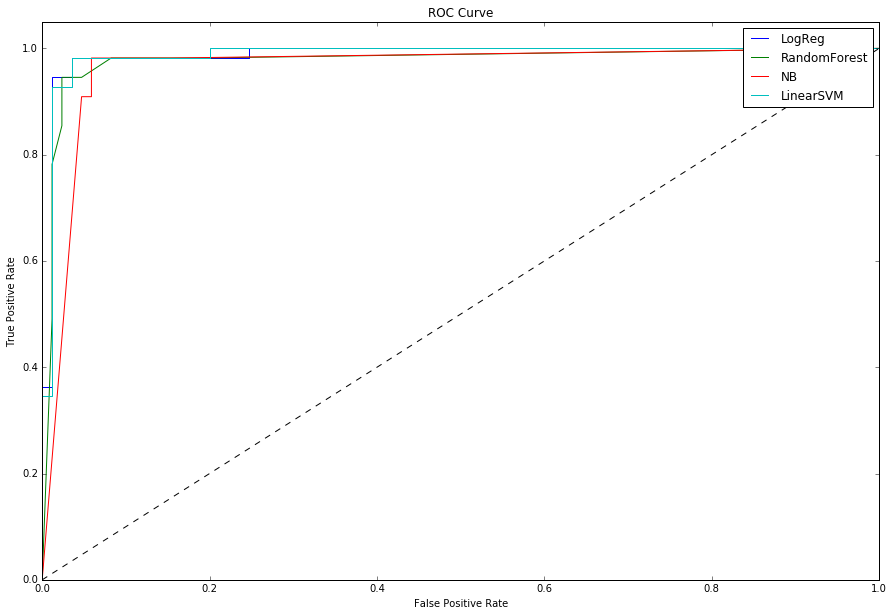

In [33]:
plt.figure(figsize=(15,10))
plt.plot(fpr_lr,tpr_lr)
plt.plot(fpr_rf,tpr_rf)
plt.plot(fpr_nb,tpr_nb)
plt.plot(fpr_lsvc,tpr_lsvc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(['LogReg','RandomForest','NB','LinearSVM'])
plt.show()

In [34]:
print('ROC AUC Scores:')
print('LogReg = ','%0.4f'%roc_score_lr)
print('RandomForest = ','%0.4f'%roc_score_rf)
print('NB = ','%0.4f'%roc_score_nb)
print('LinearSVM = ','%0.4f'%roc_score_lsvc)

ROC AUC Scores:
LogReg =  0.9874
RandomForest =  0.9771
NB =  0.9639
LinearSVM =  0.9876


In [35]:
print('Recall Scores:')
print('LogReg = ','%0.4f'%recall_lr)
print('RandomForest = ','%0.4f'%recall_rf)
print('NB = ','%0.4f'%recall_nb)
print('LinearSVM = ','%0.4f'%recall_lsvc)

Recall Scores:
LogReg =  0.9455
RandomForest =  0.9455
NB =  0.9818
LinearSVM =  0.9818


# Conclusion

Linear SVM and Logistic Regression almost tie in ROC score, however the Linear SVM has better recall. 
Recall is important in this case since we want to maximize catching malignant tumors. Thus I recommend using my LinearSVM for prediction. The fully trained model is set up below.

In [36]:
model = svm.LinearSVC(class_weight='balanced')
model = model.fit(data[features],data.result)